In [6]:
import numpy as np
import time
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, ElasticNet

In [4]:
def optimized_new_bvls(X, y, l, u, epsilon_kkt=1e-5, max_iter=1000):
    start_time = time.time()
    n, p = X.shape
    kappa = min(n, p)  # Approximation for rank(X)
    beta = np.where(np.abs(l) < np.abs(u), l, u)  # Initialize beta
    S = set()  # Active set for violations
    A = set()  # Active set for coordinate descent

    def compute_gradient(beta):
        # Compute the gradient
        return -X.T @ (y - X @ beta)
    
    def violations_delta(grad, beta):
        # Compute violations delta based on the bounds.
        return np.maximum(np.where(beta > l, grad, 0), np.where(beta < u, -grad, 0))

    def coordinate_descent(beta, active_set):
        # Perform coordinate descent on the active set.
        for j in active_set:
            X_j = X[:, j]
            residual = y - X @ beta + beta[j] * X_j
            beta_j_new = (X_j @ residual) / (X_j @ X_j)
            beta[j] = np.clip(beta_j_new, l[j], u[j])
        return beta
  
    for i in range(max_iter):
        grad = compute_gradient(beta)
        violations = violations_delta(grad, beta)
        violations_sorted_indices = np.argsort(-violations)  # Sort delta in decreasing order
        kkt_check = True  # KKT conditions flag
        S_old = S.copy()

        # Update S based on the largest violations
        for j in range(p):
            idx = violations_sorted_indices[j]
            if violations[idx] <= epsilon_kkt * np.linalg.norm(X[:, idx]) * np.linalg.norm(y):
                continue  # Stop if delta does not exceed threshold
            kkt_check = False
            if len(S) - len(S_old) == kappa:
                break # Stop if the number of active variables exceeds the rank of X
            S.add(idx)

        # Check if KKT conditions are satisfied
        if kkt_check:
            break
        
        for it in range(max_iter):
            beta = coordinate_descent(beta, S)  # Perform one cycle of coordinate descent on S
            A.update(S)  # Add all active variables in S to A

            # Check for convergence on S
            grad = compute_gradient(beta)
            violations = violations_delta(grad, beta)
            if all(violations[j] <= epsilon_kkt * np.linalg.norm(X[:, j]) * np.linalg.norm(y) for j in S):
                A = {j for j in A if l[j] < beta[j] < u[j]} # Remove binding coefficients from A
                break  # Stop if KKT conditions are satisfied on S

            # Perform coordinate descent on A until convergence
            for ite in range(max_iter):
                beta = coordinate_descent(beta, A)
                grad = compute_gradient(beta)
                violations = violations_delta(grad, beta)
                if all(violations[j] <= epsilon_kkt * np.linalg.norm(X[:, j]) * np.linalg.norm(y) for j in A):
                    A = {j for j in A if l[j] < beta[j] < u[j]} # Remove binding coefficients from A
                    break  

    runtime = time.time() - start_time
    active_set_size = len(S)
    objective_value = 0.5 * np.linalg.norm(y - X @ beta) ** 2
    return beta, runtime, active_set_size, objective_value

Scipy NNLS: mu=-3.0, runtime=48.0385s, objective=519.8707
Paper NNLS: mu=-3.0, runtime=0.1040s, active set size=0, objective=519.8707
Scipy NNLS: mu=-2.6842105263157894, runtime=47.2631s, objective=378.4939
Paper NNLS: mu=-2.6842105263157894, runtime=0.1072s, active set size=0, objective=378.4939
Scipy NNLS: mu=-2.3684210526315788, runtime=40.5043s, objective=316.5778
Paper NNLS: mu=-2.3684210526315788, runtime=0.0996s, active set size=0, objective=316.5778
Scipy NNLS: mu=-2.0526315789473686, runtime=47.6087s, objective=259.4350
Paper NNLS: mu=-2.0526315789473686, runtime=0.0984s, active set size=0, objective=259.4350
Scipy NNLS: mu=-1.736842105263158, runtime=42.3548s, objective=194.7715
Paper NNLS: mu=-1.736842105263158, runtime=0.0991s, active set size=0, objective=194.7715
Scipy NNLS: mu=-1.4210526315789473, runtime=42.4502s, objective=148.2279
Paper NNLS: mu=-1.4210526315789473, runtime=0.1012s, active set size=0, objective=148.2279
Scipy NNLS: mu=-1.105263157894737, runtime=45.80

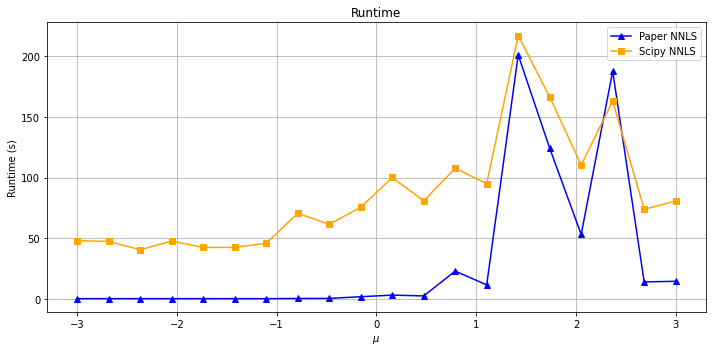

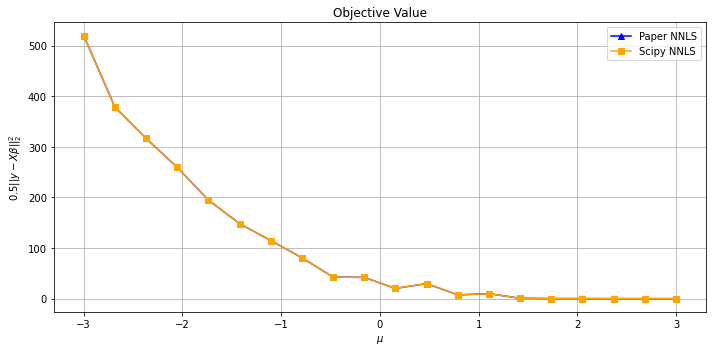

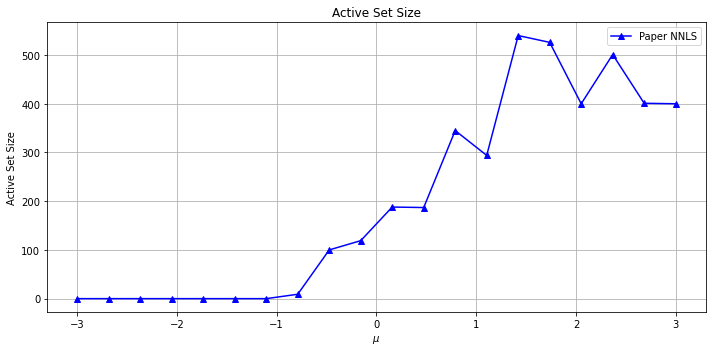

In [8]:
n = 100  # Number of samples
p = 10000  # Number of features (high-dimensional case)

np.random.seed(0)
X = np.random.uniform(0, 1, (n, p))  # Non-negative matrix from Uniform(0, 1)
mask = np.random.rand(n, p) < 0.8  # Setting 80% of entries to zero
X[mask] = 0  # Apply sparsity

# Define bounds (NNLS)
lower_bound_nnls = np.zeros(p)  # lower bound = 0
upper_bound_nnls = np.inf * np.ones(p)  # upper bound = ∞

sigma = 1
mu_values = np.linspace(-3 * sigma, 3 * sigma, 20)

# Store results
time_custom = []
time_scipy = []
active_set_sizes = []
objective_custom = []
objective_scipy = []

for mu in mu_values:
    y = np.random.normal(mu, sigma, n)
    
    # Solve using scipy NNLS
    start_time = time.time()
    res = lsq_linear(X, y, bounds=(lower_bound_nnls, upper_bound_nnls), lsmr_tol='auto', verbose=0)
    elapsed_time = time.time() - start_time
    print(f"Scipy NNLS: mu={mu}, runtime={elapsed_time:.4f}s, objective={0.5 * np.linalg.norm(y - X @ res.x) ** 2:.4f}")
    time_scipy.append(elapsed_time)
    objective_scipy.append(0.5 * np.linalg.norm(y - X @ res.x) ** 2)

    # Solve using the paper NNLS implementation
    _, runtime, active_set_size, objective_value = optimized_new_bvls(X, y, lower_bound_nnls, upper_bound_nnls)
    print(f"Paper NNLS: mu={mu}, runtime={runtime:.4f}s, active set size={active_set_size}, objective={objective_value:.4f}")
    time_custom.append(runtime)
    active_set_sizes.append(active_set_size)
    objective_custom.append(objective_value)
    

# Plot runtime
plt.figure(figsize=(10, 5))
plt.plot(mu_values, time_custom, label='Paper NNLS', color='blue', marker='^')
plt.plot(mu_values, time_scipy, label='Scipy NNLS', color='orange', marker='s')
plt.title('Runtime')
plt.xlabel('$\mu$')
plt.ylabel('Runtime (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot objective value
plt.figure(figsize=(10, 5))
plt.plot(mu_values, objective_custom, label='Paper NNLS', color='blue', marker='^')
plt.plot(mu_values, objective_scipy, label='Scipy NNLS', color='orange', marker='s')
plt.title('Objective Value')
plt.xlabel('$\mu$')
plt.ylabel('$0.5||y - X \\beta||^2_2$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot active set size
plt.figure(figsize=(10, 5))
plt.plot(mu_values, active_set_sizes, label='Paper NNLS', color='blue', marker='^')
plt.title('Active Set Size')
plt.xlabel('$\mu$')
plt.ylabel('Active Set Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
n = 100  # Number of samples
p = 10000  # Number of features (high-dimensional case)

np.random.seed(0)
X = np.random.uniform(0, 1, (n, p))  # Non-negative matrix from Uniform(0, 1)
mask = np.random.rand(n, p) < 0.8  # Setting 80% of entries to zero
X[mask] = 0  # Apply sparsity

# Define bounds (BVLS)
lower_bound_bvls = np.zeros(p)  # lower bound = 0
upper_bound_bvls = np.ones(p)  # upper bound = 1

sigma = 1
mu_values = np.linspace(-3 * sigma, 3 * sigma, 20)

# Store results
time_custom = []
time_scipy = []
active_set_sizes = []
objective_custom = []
objective_scipy = []

for mu in mu_values:
    y = np.random.normal(mu, sigma, n)
    
    # Solve using scipy BVLS
    start_time = time.time()
    res = lsq_linear(X, y, bounds=(lower_bound_bvls, upper_bound_bvls), lsmr_tol='auto', verbose=0)
    elapsed_time = time.time() - start_time
    print(f"Scipy BVLS: mu={mu}, runtime={elapsed_time:.4f}s, objective={0.5 * np.linalg.norm(y - X @ res.x) ** 2:.4f}")
    time_scipy.append(elapsed_time)
    objective_scipy.append(0.5 * np.linalg.norm(y - X @ res.x) ** 2)

    # Solve using the custom optimized BVLS implementation
    _, runtime, active_set_size, objective_value = optimized_new_bvls(X, y, lower_bound_bvls, upper_bound_bvls)
    print(f"Paper BVLS: mu={mu}, runtime={runtime:.4f}s, active set size={active_set_size}, objective={objective_value:.4f}")
    time_custom.append(runtime)
    active_set_sizes.append(active_set_size)
    objective_custom.append(objective_value)

# Plot runtime
plt.figure(figsize=(10, 5))
plt.plot(mu_values, time_custom, label='Paper BVLS', color='blue', marker='^')
plt.plot(mu_values, time_scipy, label='Scipy BVLS', color='orange', marker='s')
plt.title('Runtime')
plt.xlabel('$μ$')
plt.ylabel('Runtime (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot objective value
plt.figure(figsize=(10, 5))
plt.plot(mu_values, objective_custom, label='Paper BVLS', color='blue', marker='^')
plt.plot(mu_values, objective_scipy, label='Scipy BVLS', color='orange', marker='s')
plt.title('Objective Value')
plt.xlabel('$μ$')
plt.ylabel('$0.5||y - Xβ||^2_2$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot active set size
plt.figure(figsize=(10, 5))
plt.plot(mu_values, active_set_sizes, label='Paper BVLS', color='blue', marker='^')
plt.title('Active Set Size')
plt.xlabel('$μ$')
plt.ylabel('Active Set Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Scipy BVLS: mu=-3.0, runtime=41.5998s, objective=519.8707
Paper BVLS: mu=-3.0, runtime=0.0980s, active set size=0, objective=519.8707
Scipy BVLS: mu=-2.6842105263157894, runtime=38.1488s, objective=378.4939
Paper BVLS: mu=-2.6842105263157894, runtime=0.1039s, active set size=0, objective=378.4939
Scipy BVLS: mu=-2.3684210526315788, runtime=37.6136s, objective=316.5778
Paper BVLS: mu=-2.3684210526315788, runtime=0.1002s, active set size=0, objective=316.5778
Scipy BVLS: mu=-2.0526315789473686, runtime=39.3772s, objective=259.4350
Paper BVLS: mu=-2.0526315789473686, runtime=0.0985s, active set size=0, objective=259.4350
Scipy BVLS: mu=-1.736842105263158, runtime=44.5938s, objective=194.7715
Paper BVLS: mu=-1.736842105263158, runtime=0.0997s, active set size=0, objective=194.7715
Scipy BVLS: mu=-1.4210526315789473, runtime=44.8941s, objective=148.2279
Paper BVLS: mu=-1.4210526315789473, runtime=0.1022s, active set size=0, objective=148.2279
Scipy BVLS: mu=-1.105263157894737, runtime=49.92